### MODULE IMPORT

In [6]:
import os
import shutil

In [7]:
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

from glob import glob
from tqdm import tqdm

##### PATH

In [8]:
# INPUT_DIR = os.path.join("..", "input")/content/drive/MyDrive/3차플젝drive/test/KAGGLE/Segment/input
INPUT_DIR = '/content/drive/MyDrive/3차플젝drive/test/KAGGLE/Segment/input'

SEGMENTATION_DIR = os.path.join(INPUT_DIR, "segmentation")
SEGMENTATION_TEST_DIR = os.path.join(SEGMENTATION_DIR, "test")
SEGMENTATION_TRAIN_DIR = os.path.join(SEGMENTATION_DIR, "train")
SEGMENTATION_AUG_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "augmentation")
SEGMENTATION_IMAGE_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "image")
SEGMENTATION_MASK_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "mask")
SEGMENTATION_DILATE_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "dilate")
SEGMENTATION_SOURCE_DIR = os.path.join(INPUT_DIR, \
                                       "pulmonary-chest-xray-abnormalities")

SHENZHEN_TRAIN_DIR = os.path.join(SEGMENTATION_SOURCE_DIR, "ChinaSet_AllFiles", \
                                  "ChinaSet_AllFiles")
SHENZHEN_IMAGE_DIR = os.path.join(SHENZHEN_TRAIN_DIR, "CXR_png")
SHENZHEN_MASK_DIR = os.path.join(INPUT_DIR, "shcxr-lung-mask", "mask", "mask")

MONTGOMERY_TRAIN_DIR = os.path.join(SEGMENTATION_SOURCE_DIR, \
                                    "Montgomery", "MontgomerySet")
MONTGOMERY_IMAGE_DIR = os.path.join(MONTGOMERY_TRAIN_DIR, "CXR_png")
MONTGOMERY_LEFT_MASK_DIR = os.path.join(MONTGOMERY_TRAIN_DIR, \
                                        "ManualMask", "leftMask")
MONTGOMERY_RIGHT_MASK_DIR = os.path.join(MONTGOMERY_TRAIN_DIR, \
                                         "ManualMask", "rightMask")

DILATE_KERNEL = np.ones((15, 15), np.uint8)

BATCH_SIZE =2

#Prod
EPOCHS = 100

#Desv
#EPOCHS=16

In [9]:
# !mkdir /content/drive/MyDrive/3차플젝drive/test/KAGGLE/Segment/input/segmentation
# !mkdir /content/drive/MyDrive/3차플젝drive/test/KAGGLE/Segment/input/segmentation/test
# !mkdir /content/drive/MyDrive/3차플젝drive/test/KAGGLE/Segment/input/segmentation/train
# !mkdir /content/drive/MyDrive/3차플젝drive/test/KAGGLE/Segment/input/segmentation/augmentation
# !mkdir /content/drive/MyDrive/3차플젝drive/test/KAGGLE/Segment/input/segmentation/image
# !mkdir /content/drive/MyDrive/3차플젝drive/test/KAGGLE/Segment/input/segmentation/mask
# !mkdir /content/drive/MyDrive/3차플젝drive/test/KAGGLE/Segment/input/segmentation/dilate

In [10]:
print('SEGMENTATION_DIR              ',SEGMENTATION_DIR)
print('SEGMENTATION_TEST_DIR              ',SEGMENTATION_TEST_DIR)
print('SEGMENTATION_TRAIN_DIR              ',SEGMENTATION_TRAIN_DIR)
print('SEGMENTATION_AUG_DIR              ',SEGMENTATION_AUG_DIR)
print('SEGMENTATION_IMAGE_DIR              ',SEGMENTATION_IMAGE_DIR)
print('SEGMENTATION_MASK_DIR              ',SEGMENTATION_MASK_DIR)
print('SEGMENTATION_DILATE_DIR              ',SEGMENTATION_DILATE_DIR)
print('SEGMENTATION_SOURCE_DIR              ',SEGMENTATION_SOURCE_DIR)
print('SHENZHEN_TRAIN_DIR              ',SHENZHEN_TRAIN_DIR)
print('SHENZHEN_IMAGE_DIR              ',SHENZHEN_IMAGE_DIR)
print('SHENZHEN_MASK_DIR              ',SHENZHEN_MASK_DIR)
print('MONTGOMERY_TRAIN_DIR              ',MONTGOMERY_TRAIN_DIR)
print('MONTGOMERY_IMAGE_DIR              ',MONTGOMERY_IMAGE_DIR)
print('MONTGOMERY_LEFT_MASK_DIR              ',MONTGOMERY_LEFT_MASK_DIR)
print('MONTGOMERY_RIGHT_MASK_DIR              ',MONTGOMERY_RIGHT_MASK_DIR)

SEGMENTATION_DIR               /content/drive/MyDrive/3차플젝drive/test/KAGGLE/Segment/input/segmentation
SEGMENTATION_TEST_DIR               /content/drive/MyDrive/3차플젝drive/test/KAGGLE/Segment/input/segmentation/test
SEGMENTATION_TRAIN_DIR               /content/drive/MyDrive/3차플젝drive/test/KAGGLE/Segment/input/segmentation/train
SEGMENTATION_AUG_DIR               /content/drive/MyDrive/3차플젝drive/test/KAGGLE/Segment/input/segmentation/train/augmentation
SEGMENTATION_IMAGE_DIR               /content/drive/MyDrive/3차플젝drive/test/KAGGLE/Segment/input/segmentation/train/image
SEGMENTATION_MASK_DIR               /content/drive/MyDrive/3차플젝drive/test/KAGGLE/Segment/input/segmentation/train/mask
SEGMENTATION_DILATE_DIR               /content/drive/MyDrive/3차플젝drive/test/KAGGLE/Segment/input/segmentation/train/dilate
SEGMENTATION_SOURCE_DIR               /content/drive/MyDrive/3차플젝drive/test/KAGGLE/Segment/input/pulmonary-chest-xray-abnormalities
SHENZHEN

In [11]:
print(len(MONTGOMERY_TRAIN_DIR))
print(len(MONTGOMERY_IMAGE_DIR))
print(len(MONTGOMERY_LEFT_MASK_DIR))
print(len(SHENZHEN_IMAGE_DIR))

123
131
143
142


## TRAINING FILE_MONT

In [12]:
montgomery_left_mask_dir = glob(os.path.join(MONTGOMERY_LEFT_MASK_DIR, '*.png'))
montgomery_test = montgomery_left_mask_dir[0:50]
montgomery_train= montgomery_left_mask_dir[50:]

for left_image_file in tqdm(montgomery_left_mask_dir):
    base_file = os.path.basename(left_image_file)
    image_file = os.path.join(MONTGOMERY_IMAGE_DIR, base_file)
    right_image_file = os.path.join(MONTGOMERY_RIGHT_MASK_DIR, base_file)

    image = cv2.imread(image_file)
    left_mask = cv2.imread(left_image_file, cv2.IMREAD_GRAYSCALE)
    right_mask = cv2.imread(right_image_file, cv2.IMREAD_GRAYSCALE)
    
    image = cv2.resize(image, (512, 512))
    left_mask = cv2.resize(left_mask, (512, 512))
    right_mask = cv2.resize(right_mask, (512, 512))
    
    mask = np.maximum(left_mask, right_mask)
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)
    
    if (left_image_file in montgomery_train):
        cv2.imwrite(os.path.join(SEGMENTATION_IMAGE_DIR, base_file), \
                    image)
        cv2.imwrite(os.path.join(SEGMENTATION_MASK_DIR, base_file), \
                    mask)
        cv2.imwrite(os.path.join(SEGMENTATION_DILATE_DIR, base_file), \
                    mask_dilate)
    else:
        filename, fileext = os.path.splitext(base_file)
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, base_file), \
                    image)
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_mask%s" % (filename, fileext)), mask)
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_dilate%s" % (filename, fileext)), mask_dilate)

100%|██████████| 138/138 [03:40<00:00,  1.60s/it]


In [13]:
def add_colored_dilate(image, mask_image, dilate_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    dilate_image_gray = cv2.cvtColor(dilate_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    dilate = cv2.bitwise_and(dilate_image, dilate_image, mask=dilate_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])
    dilate_coord = np.where(dilate!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]
    dilate[dilate_coord[0],dilate_coord[1],:] = [0,0,255]

    ret = cv2.addWeighted(image, 0.7, dilate, 0.3, 0)
    ret = cv2.addWeighted(ret, 0.7, mask, 0.3, 0)

    return ret

def add_colored_mask(image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(image, 0.7, mask, 0.3, 0)

    return ret

def diff_mask(ref_image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(ref_image, 0.7, mask, 0.3, 0)
    return ret

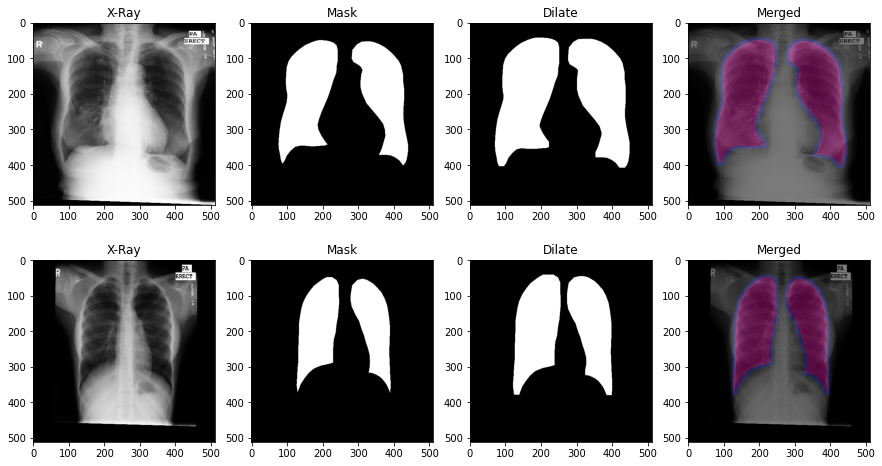

In [14]:
base_file = os.path.basename(montgomery_train[0])

image_file = os.path.join(SEGMENTATION_IMAGE_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_MASK_DIR, base_file)
dilate_image_file = os.path.join(SEGMENTATION_DILATE_DIR, base_file)

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)
                          
fig, axs = plt.subplots(2, 4, figsize=(15, 8))

axs[0, 0].set_title("X-Ray")
axs[0, 0].imshow(image)

axs[0, 1].set_title("Mask")
axs[0, 1].imshow(mask_image)

axs[0, 2].set_title("Dilate")
axs[0, 2].imshow(dilate_image)

axs[0, 3].set_title("Merged")
axs[0, 3].imshow(merged_image)

base_file = os.path.basename(montgomery_test[0])
filename, fileext = os.path.splitext(base_file)
image_file = os.path.join(SEGMENTATION_TEST_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                               "%s_mask%s" % (filename, fileext))
dilate_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_dilate%s" % (filename, fileext))

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)

axs[1, 0].set_title("X-Ray")
axs[1, 0].imshow(image)

axs[1, 1].set_title("Mask")
axs[1, 1].imshow(mask_image)

axs[1, 2].set_title("Dilate")
axs[1, 2].imshow(dilate_image)

axs[1, 3].set_title("Merged")
axs[1, 3].imshow(merged_image)

### THRAINING FILE SHENZEHN

In [15]:
shenzhen_mask_dir = glob(os.path.join(SHENZHEN_MASK_DIR, '*.png'))
shenzhen_test = shenzhen_mask_dir[0:50]
shenzhen_train= shenzhen_mask_dir[50:]

for mask_file in tqdm(shenzhen_mask_dir):
    base_file = os.path.basename(mask_file).replace("_mask", "")
    image_file = os.path.join(SHENZHEN_IMAGE_DIR, base_file)

    image = cv2.imread(image_file)
    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
        
    image = cv2.resize(image, (512, 512))
    mask = cv2.resize(mask, (512, 512))
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)
    
    if (mask_file in shenzhen_train):
        cv2.imwrite(os.path.join(SEGMENTATION_IMAGE_DIR, base_file), \
                    image)
        cv2.imwrite(os.path.join(SEGMENTATION_MASK_DIR, base_file), \
                    mask)
        cv2.imwrite(os.path.join(SEGMENTATION_DILATE_DIR, base_file), \
                    mask_dilate)
    else:
        filename, fileext = os.path.splitext(base_file)

        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, base_file), \
                    image)
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_mask%s" % (filename, fileext)), mask)
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_dilate%s" % (filename, fileext)), mask_dilate)

100%|██████████| 566/566 [12:40<00:00,  1.34s/it]


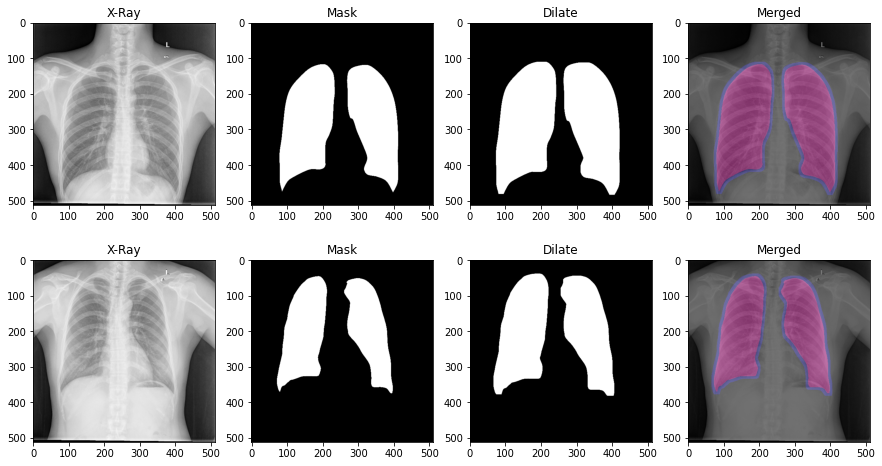

In [16]:
base_file = os.path.basename(shenzhen_train[0].replace("_mask", ""))

image_file = os.path.join(SEGMENTATION_IMAGE_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_MASK_DIR, base_file)
dilate_image_file = os.path.join(SEGMENTATION_DILATE_DIR, base_file)

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)
                          
fig, axs = plt.subplots(2, 4, figsize=(15, 8))

axs[0, 0].set_title("X-Ray")
axs[0, 0].imshow(image)

axs[0, 1].set_title("Mask")
axs[0, 1].imshow(mask_image)

axs[0, 2].set_title("Dilate")
axs[0, 2].imshow(dilate_image)

axs[0, 3].set_title("Merged")
axs[0, 3].imshow(merged_image)

base_file = os.path.basename(shenzhen_test[0].replace("_mask", ""))
image_file = os.path.join(SEGMENTATION_TEST_DIR, base_file)
filename, fileext = os.path.splitext(base_file)
mask_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                               "%s_mask%s" % (filename, fileext))

filename, fileext = os.path.splitext(base_file)
image_file = os.path.join(SEGMENTATION_TEST_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                               "%s_mask%s" % (filename, fileext))
dilate_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_dilate%s" % (filename, fileext))

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)

axs[1, 0].set_title("X-Ray")
axs[1, 0].imshow(image)

axs[1, 1].set_title("Mask")
axs[1, 1].imshow(mask_image)

axs[1, 2].set_title("Dilate")
axs[1, 2].imshow(dilate_image)

axs[1, 3].set_title("Merged")
axs[1, 3].imshow(merged_image)

##### TRAIN FILE CHECK

In [17]:
train_files = glob(os.path.join(SEGMENTATION_IMAGE_DIR, "*.png"))
test_files = glob(os.path.join(SEGMENTATION_TEST_DIR, "*.png"))
mask_files = glob(os.path.join(SEGMENTATION_MASK_DIR, "*.png"))
dilate_files = glob(os.path.join(SEGMENTATION_DILATE_DIR, "*.png"))

(len(train_files), \
 len(test_files), \
 len(mask_files), \
 len(dilate_files))

(604, 300, 604, 604)

In [18]:
train_files = glob(os.path.join(SEGMENTATION_IMAGE_DIR, "*.png"))
test_files = glob(os.path.join(SEGMENTATION_TEST_DIR, "*.png"))
mask_files = glob(os.path.join(SEGMENTATION_MASK_DIR, "*.png"))
dilate_files = glob(os.path.join(SEGMENTATION_DILATE_DIR, "*.png"))

(len(train_files), \
 len(test_files), \
 len(mask_files), \
 len(dilate_files))

(604, 300, 604, 604)

In [19]:
def train_generator(batch_size, train_path, image_folder, mask_folder, aug_dict,
        image_color_mode="grayscale",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [20]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [21]:
def test_load_image(test_file, target_size=(256,256)):
    img = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
    img = img / 255
    img = cv2.resize(img, target_size)
    img = np.reshape(img, img.shape + (1,))
    img = np.reshape(img,(1,) + img.shape)
    return img

def test_generator(test_files, target_size=(256,256)):
    for test_file in test_files:
        yield test_load_image(test_file, target_size)
        
def save_result(save_path, npyfile, test_files):
    for i, item in enumerate(npyfile):
        result_file = test_files[i]
        img = (item[:, :, 0] * 255.).astype(np.uint8)

        filename, fileext = os.path.splitext(os.path.basename(result_file))

        result_file = os.path.join(save_path, "%s_predict%s" % (filename, fileext))

        cv2.imwrite(result_file, img)

In [22]:
def add_suffix(base_file, suffix):
    filename, fileext = os.path.splitext(base_file)
    return "%s_%s%s" % (filename, suffix, fileext)

test_files = [test_file for test_file in glob(os.path.join(SEGMENTATION_TEST_DIR, "*.png")) \
              if ("_mask" not in test_file \
                  and "_dilate" not in test_file \
                  and "_predict" not in test_file)]

validation_data = (test_load_image(test_files[0], target_size=(512, 512)),
                    test_load_image(add_suffix(test_files[0], "dilate"), target_size=(512, 512)))

len(test_files), len(validation_data)

(100, 2)

In [23]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(BATCH_SIZE,
                            SEGMENTATION_TRAIN_DIR,
                            'image',
                            'dilate', 
                            train_generator_args,
                            target_size=(512,512),
                            save_to_dir=os.path.abspath(SEGMENTATION_AUG_DIR))

model = unet(input_size=(512,512,1))
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, \
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()


model_EarlyStopping = EarlyStopping(monitor='loss', patience=5)

model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/3차플젝drive/test/check/unet_lung_seg.hdf5', 
                                   monitor='loss', 
                                   verbose=1, 
                                   save_best_only=True)

history = model.fit_generator(train_gen,
                              steps_per_epoch=len(train_files) / BATCH_SIZE,    
                              epochs=EPOCHS, 
                              callbacks=[model_EarlyStopping,model_checkpoint],
                              validation_data = validation_data)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [24]:
from tensorflow.keras.models import load_model

model.save('/content/drive/MyDrive/3차플젝drive/test/model/unet_2_100.h5')

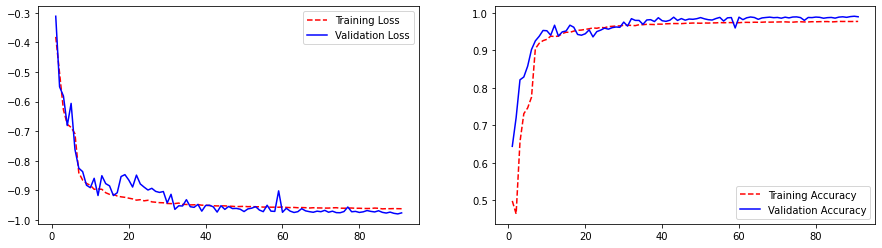

In [25]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_accuracy = history.history['binary_accuracy']
validation_accuracy = history.history['val_binary_accuracy']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy, 'r--')
axs[1].plot(epoch_count, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

In [26]:
test_gen = test_generator(test_files, target_size=(512,512))
results = model.predict_generator(test_gen, len(test_files), verbose=1)
save_result(SEGMENTATION_TEST_DIR, results, test_files)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


100/100 [==============================] - 2s 14ms/step


In [27]:
from tensorflow.keras.models import load_model

model.save('/content/drive/MyDrive/3차플젝drive/test/model/unet_2_100_2.h5')

#### MODEL LOAD

In [28]:
import tensorflow
model = tensorflow.keras.models.load_model('/content/drive/MyDrive/3차플젝drive/test/model/unet_2_100.h5')

ValueError: ignored

### TEST PREDICTION

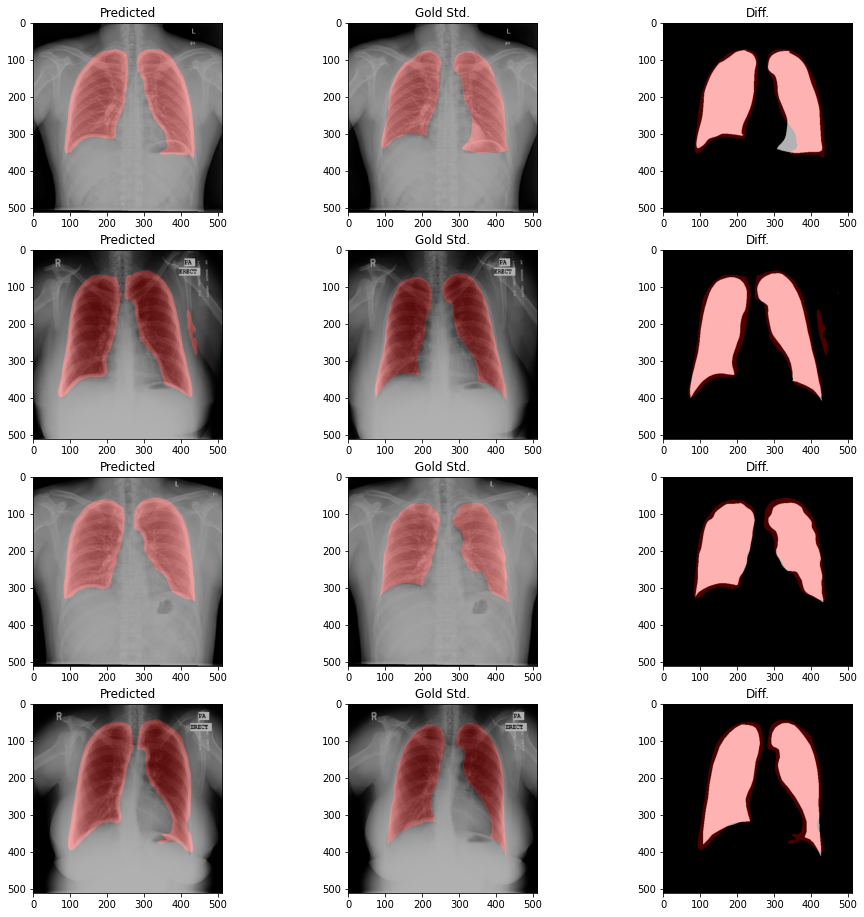

In [29]:
image = cv2.imread("/content/drive/MyDrive/3차플젝drive/test/KAGGLE/Segment/input/segmentation/test/CHNCXR_0014_0.png")
predict_image = cv2.imread("/content/drive/MyDrive/3차플젝drive/test/KAGGLE/Segment/input/segmentation/test/CHNCXR_0014_0_predict.png")
mask_image = cv2.imread("/content/drive/MyDrive/3차플젝drive/test/KAGGLE/Segment/input/segmentation/test/CHNCXR_0014_0_mask.png")

fig, axs = plt.subplots(4, 3, figsize=(16, 16))

axs[0, 0].set_title("Predicted")
axs[0, 0].imshow(add_colored_mask(image, predict_image))
axs[0, 1].set_title("Gold Std.")
axs[0, 1].imshow(add_colored_mask(image, mask_image))
axs[0, 2].set_title("Diff.")
axs[0, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/content/drive/MyDrive/3차플젝drive/test/KAGGLE/Segment/input/segmentation/test/MCUCXR_0002_0.png")
predict_image = cv2.imread("/content/drive/MyDrive/3차플젝drive/test/KAGGLE/Segment/input/segmentation/test/MCUCXR_0002_0_predict.png")
mask_image = cv2.imread("/content/drive/MyDrive/3차플젝drive/test/KAGGLE/Segment/input/segmentation/test/MCUCXR_0002_0_mask.png")

axs[1, 0].set_title("Predicted")
axs[1, 0].imshow(add_colored_mask(image, predict_image))
axs[1, 1].set_title("Gold Std.")
axs[1, 1].imshow(add_colored_mask(image, mask_image))
axs[1, 2].set_title("Diff.")
axs[1, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/content/drive/MyDrive/3차플젝drive/test/KAGGLE/Segment/input/segmentation/test/CHNCXR_0237_0.png")
predict_image = cv2.imread("/content/drive/MyDrive/3차플젝drive/test/KAGGLE/Segment/input/segmentation/test/CHNCXR_0237_0_predict.png")
mask_image = cv2.imread("/content/drive/MyDrive/3차플젝drive/test/KAGGLE/Segment/input/segmentation/test/CHNCXR_0237_0_mask.png")

axs[2, 0].set_title("Predicted")
axs[2, 0].imshow(add_colored_mask(image, predict_image))
axs[2, 1].set_title("Gold Std.")
axs[2, 1].imshow(add_colored_mask(image, mask_image))
axs[2, 2].set_title("Diff.")
axs[2, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/content/drive/MyDrive/3차플젝drive/test/KAGGLE/Segment/input/segmentation/test/MCUCXR_0084_0.png")
predict_image = cv2.imread("/content/drive/MyDrive/3차플젝drive/test/KAGGLE/Segment/input/segmentation/test/MCUCXR_0084_0_predict.png")
mask_image = cv2.imread("/content/drive/MyDrive/3차플젝drive/test/KAGGLE/Segment/input/segmentation/test/MCUCXR_0084_0_mask.png")

axs[3, 0].set_title("Predicted")
axs[3, 0].imshow(add_colored_mask(image, predict_image))
axs[3, 1].set_title("Gold Std.")
axs[3, 1].imshow(add_colored_mask(image, mask_image))
axs[3, 2].set_title("Diff.")
axs[3, 2].imshow(diff_mask(mask_image, predict_image))

### REAL TEST_KAGGLE

In [30]:
import cv2
t_file = '/content/drive/MyDrive/3차플젝drive/test/t'
files = glob(os.path.join(t_file, "*.jpg"))
save_dir = '/content/drive/MyDrive/3차플젝drive/test/t/predict'

In [31]:
t_gen= test_generator(files, target_size=(512,512))
B = model.predict_generator(t_gen, len(files), verbose=1)
save_result(save_dir, B, files)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


3/3 [==============================] - 1s 345ms/step


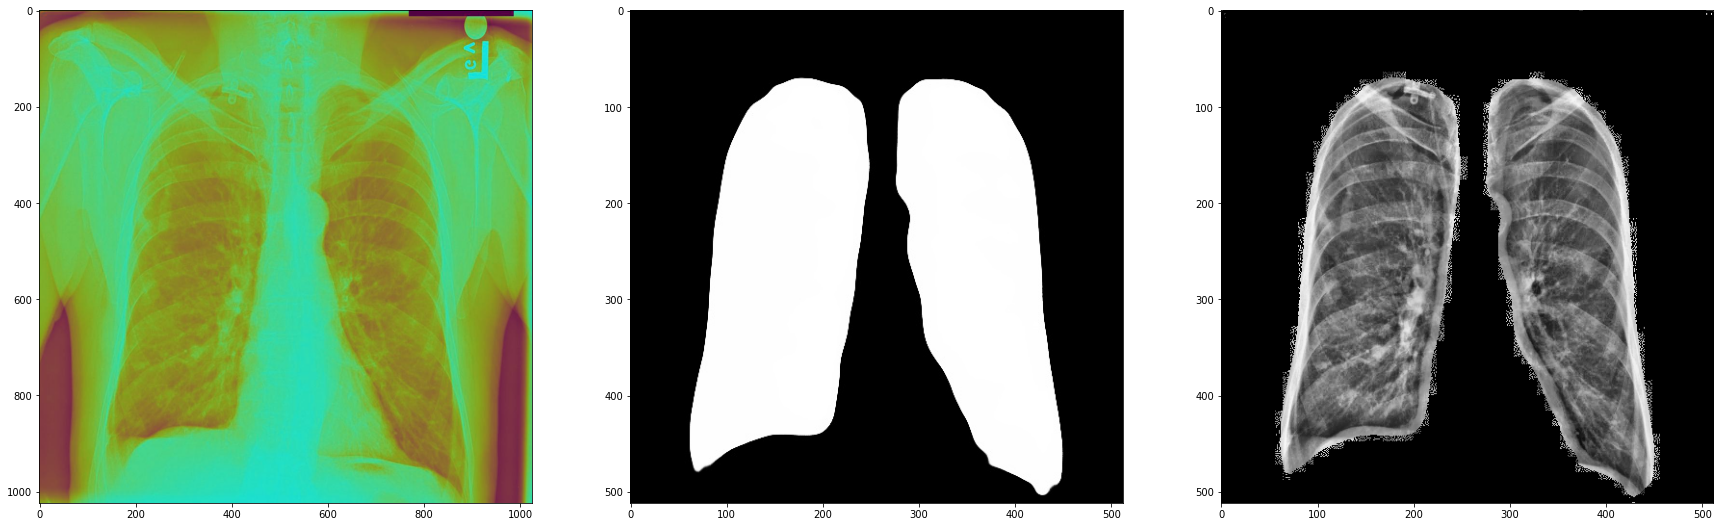

In [34]:
og_img_path = '/content/drive/MyDrive/3차플젝drive/test/t/00d7c36e-3cdf-4df6-ac03-6c30cdc8e85b.jpg'
mask_path = '/content/drive/MyDrive/3차플젝drive/test/t/predict/00d7c36e-3cdf-4df6-ac03-6c30cdc8e85b_predict.jpg'
size = (512,512)

og_img = cv2.imread(og_img_path)
mask_img = cv2.imread(mask_path)

# kernel = np.ones((3,3),np.uint8)
# erode = cv2.erode(mask_img,kernel,iterations=5)

remove = rv_3ch(og_img_path, mask_path, size)
plt.figure(figsize=(30,20))


plt.subplot(131)
plt.imshow(og_img)

plt.subplot(132)
plt.imshow(mask_img)

plt.subplot(133)
plt.imshow(remove)

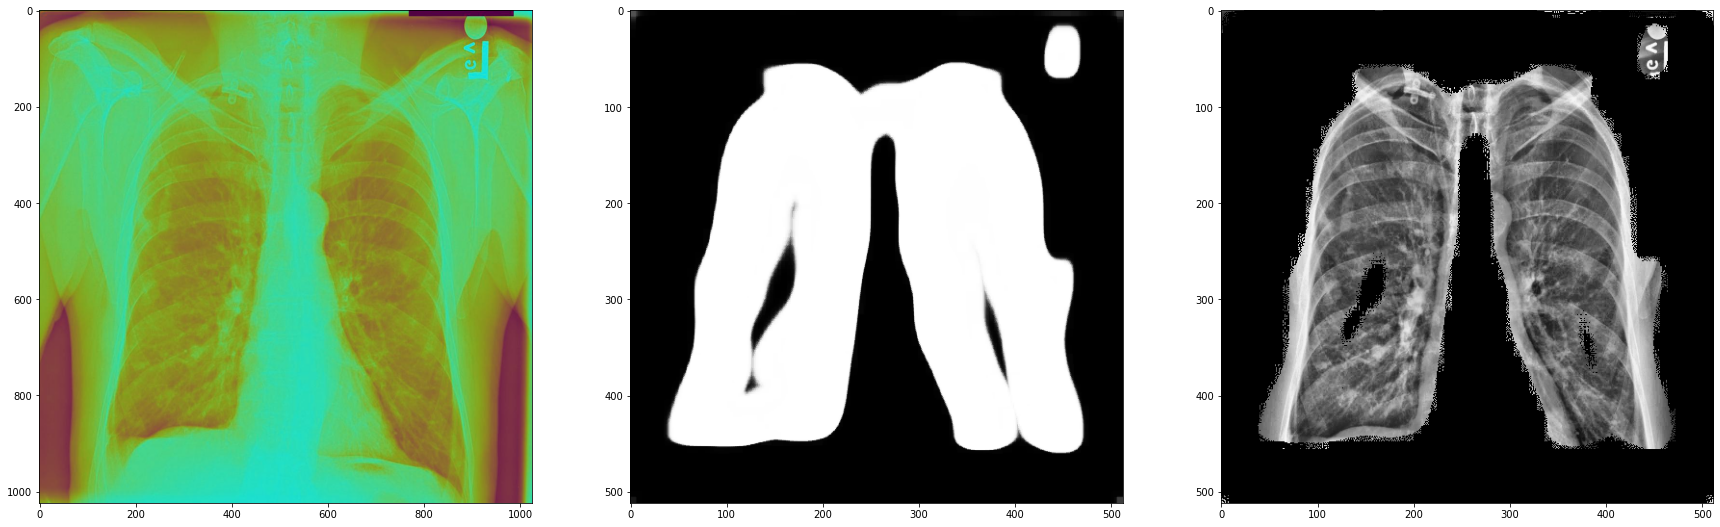

In [33]:
def rv_3ch(og_img_path, mask_path, size):
    
    #module import
    import cv2
    
    # im_read
    og_img = cv2.imread(og_img_path)
    mask = cv2.imread(mask_path)
    
    # clahe
    clahe = cv2.createCLAHE(5.0,(12,12))
    
    ## og_img_convert
    cvt_img = cv2.resize(og_img, size)
    cvt_img = cv2.cvtColor(cvt_img,cv2.COLOR_BGR2GRAY)
    cvt_img = clahe.apply(cvt_img)  # 1 channel
    cvt_img = np.repeat(cvt_img[:,:,np.newaxis],3,-1)

    ## mask
    cvt_mask = cv2.resize(mask, size)
    cvt_mask = cv2.cvtColor(cvt_mask, cv2.COLOR_BGR2GRAY)

    ## remove
    remove = cv2.bitwise_and(cvt_img, cvt_img, mask = cvt_mask)
    
    return remove

In [ ]:
import pandas as pd
total_data = pd.read_csv('/content/drive/MyDrive/3차플젝drive/공모전_이전_캐글/PD/total_file.csv',index_col=0)
a = list(total_data['id'])
len(a)

In [ ]:
from glob import glob
og_train_path = '/content/drive/MyDrive/3차플젝drive/공모전_이전_캐글/PD/penumonia/stage_2_train_images/'
og_tr_list = glob(og_train_path + "*.dcm")
len(og_tr_list)

In [ ]:
tr_normal_path ='/content/drive/MyDrive/3차플젝drive/공모전_이전_캐글/PD/penumonia/원본트레인전체이미지/'
tr_normal_list = glob(tr_normal_path + '*.jpg')

tr_pneu_path = '/content/drive/MyDrive/3차플젝drive/공모전_이전_캐글/PD/penumonia/원본트레인전체이미지/pneumonia/'
tr_pneu_list = glob(tr_pneu_path+"*.jpg")

print(len(tr_normal_list))
print(len(tr_pneu_list))

In [ ]:
normal_files = glob('/content/drive/.shortcut-targets-by-id/1BX4a76ZgAV3v_4f92zIjOVpwJ6RMMxJZ/3차플젝drive/공모전_이전_캐글/PD/penumonia/원본트레인전체이미지/normal/' + '*.jpg')
pneu_files = glob('/content/drive/.shortcut-targets-by-id/1BX4a76ZgAV3v_4f92zIjOVpwJ6RMMxJZ/3차플젝drive/공모전_이전_캐글/PD/penumonia/원본트레인전체이미지/pneumonia/' + '*.jpg')

In [ ]:
ls

In [ ]:
import tensorflow
model = tensorflow.keras.models.load_model('/content/drive/MyDrive/3차플젝drive/test/unet_8_30.h5', compile=False)

In [ ]:
import cv2
t_file = '/content/drive/MyDrive/3차플젝drive/test/t'
files = glob(os.path.join(t_file, "*.jpg"))
save_dir = '/content/drive/MyDrive/3차플젝drive/test/t/predict'
t_gen= test_generator(files, target_size=(512,512))
B = model.predict_generator(t_gen, len(files), verbose=1)
save_result(save_dir, B, files)